In [1]:
pip install category_encoders

     |████████████████████████████████| 86 kB 2.2 MB/s 


In [4]:
pip install catboost

     |████████████████████████████████| 76.6 MB 2.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,log_loss,precision_score,recall_score,f1_score,roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier,AdaBoostClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1997-2003 3pt 19'9", shot clock 30s, two 20-min halves

2004-2005 3pt 20'6.5", shot clock 30s, two 20-min halves

2006-2012 3pt 20'6.5", shot clock 24s, four 10-min quarters

2013-2021 3pt 22'1.75", shot clock 24s, four 10-min quarters

I want to control for shot clock buzzer beaters since those shots are usually off balance or rushed, but shot clock resets after defensive foul and can't distinguish oreb from dreb

Another potential feature is quarter/half buzzer beater (shot with less than 2 seconds in quarter or half)

In [3]:
df = pd.read_parquet('wnba_shot_data.parquet')
players = pd.read_parquet('wnba_player_data_updated.parquet')

In [4]:
TEAMS = {
    'Atlanta Dream':'ATL',
    'Charlotte Sting':'CHA',
    'Chicago Sky':'CHI',
    'Cleveland Rockers':'CLE',
    'Connecticut Sun':'CON',
    'Dallas Wings':'DAL',
    'Detroit Shock':'DET',
    'Houston Comets':'HOU',
    'Indiana Fever':'IND',
    'Las Vegas Aces':'LVA',
    'Los Angeles Sparks':'LAS',
    'Miami Sol':'MIA',
    'Minnesota Lynx':'MIN',
    'New York Liberty':'NYL',
    'Orlando Miracle':'ORL',
    'Phoenix Mercury':'PHO',
    'Portland Fire':'POR',
    'Sacramento Monarchs':'SAC',
    'San Antonio Silver Stars':'SAN',
    'San Antonio Stars':'SAN',
    'Seattle Storm':'SEA',
    'Tulsa Shock':'TUL',
    'Utah Starzz':'UTA',
    'Washington Mystics':'WAS'
 }

df = df.merge(players[['player_id','primary_position']],on='player_id')

df = df.loc[~(df.action_type=='No Shot')].copy()
df.year = df.year.astype(int)

# df = df.loc[df.year >=2006].copy()

df['era'] = 0
df.loc[(df.year.between(1997,2000)), ['era']] = 1
df.loc[(df.year.between(2001,2004)), ['era']] = 2
df.loc[(df.year.between(2005,2008)), ['era']] = 3
df.loc[(df.year.between(2009,2012)), ['era']] = 4
df.loc[(df.year.between(2013,2016)), ['era']] = 5
df.loc[(df.year>=2017), ['era']] = 6
df  = pd.get_dummies(df, columns=['era'])


df['home'] = np.where(df.team_name.map(TEAMS) == df.htm,1,0)

df['buzzer'] = (np
                .where(
                    (df.minutes_remaining == 0) &
                    (df.seconds_remaining < 1),
                    1,
                    0
                    )
                )

df['bubble'] = (np
                .where(
                    (df.year == 2020),
                    1,
                    0
                    )
                )

df['p_sec_rem'] = ((df.minutes_remaining * 60) + (df.seconds_remaining))

# df['time'] = None
# def secondsPlayed(df):
#   if df.year >= 2006:
#     if df.period == 1:
#       df['time'] = 600 - df.p_sec_rem
#     elif (df.period > 1) & (df.period < 5):
#       df['time'] = ((df.period * 10) * 60) - df.p_sec_rem
#     elif df.period == 5:
#       df['time'] = (((4 * 10) * 60) + 300) - df.p_sec_rem
#     elif df.period == 6:
#       df['time'] = (((4 * 10) * 60) + 600) - df.p_sec_rem
#     elif df.period == 7:
#       df['time'] = (((4 * 10) * 60) + 900) - df.p_sec_rem
#   elif df.year <= 2005:
#     if df.period == 1:
#       df['time'] = 1200 - df.p_sec_rem
#     elif df.period == 2:
#       df['time'] = 2400 - df.p_sec_rem
#     elif df.period == 3:
#       df['time'] = (((2 * 20) * 60) + 300) - df.p_sec_rem
#     elif df.period == 4:
#       df['time'] = (((2 * 20) * 60) + 600) - df.p_sec_rem
#     elif df.period == 5:
#       df['time'] = (((2 * 20) * 60) + 900) - df.p_sec_rem
#     elif df.period == 6:
#       df['time'] = (((2 * 20) * 60) + 1200) - df.p_sec_rem
#     elif df.period == 7:
#       df['time'] = (((2 * 20) * 60) + 1500) - df.p_sec_rem

#   return df

# df = df.apply(secondsPlayed,axis=1)

df['time'] = (np
                .where(df['year']<=2005, 
                      np.where(df['period']==1, 
                                1200, 1800 + 300*df['period']), 
                      np.where(df['period']<5, 
                                df['period']*600, 1200 + 300*df['period'])
                      )
                - df['p_sec_rem']
                )

df = df.sort_values(by=['player_id','game_date'])
df['gp'] = (df.game_id) != (df.game_id.shift())
df['gp'] = df.groupby('player_id').gp.cumsum().sort_index()

# no idea why the code doesn't work correctly for this player, but mannually fixing it here
df.gp = np.where(
    df.player_id==1627644,
    df.gp+1,
    df.
    gp
    )

df = df.sort_values(by=['player_id','gp','time'])
df['shot_zone_avg'] = df.groupby(['player_id', 'shot_zone_basic'])['shot_made_flag'].expanding().mean().droplevel([0,1]).round(2)
df['shot_zone_avg'] = df.groupby(['player_id', 'shot_zone_basic'])['shot_made_flag'].expanding().mean().groupby(level=[0,1]).shift().droplevel([0,1]).round(2)
df.shot_zone_avg = df.shot_zone_avg.fillna(0)

df.action_type = (np
                .where(
                    (df.shot_distance == 0) &
                    (df.shot_type == '3PT Field Goal'),
                    'Layup Shot',
                    df.action_type
                    )
                )

df.action_type = (np
                .where(
                    (df.shot_distance > 0) &
                    (df.shot_distance < 19 ) &
                    (df.shot_type == '3PT Field Goal'),
                    'Jump Shot',
                    df.action_type
                    )
                )

df.shot_zone_basic = (np
                .where(
                    (df.shot_distance == 0) &
                    (df.shot_type == '3PT Field Goal'),
                    'Restricted Area',
                    df.shot_zone_basic
                    )
                )

df.shot_zone_basic = (np
                .where(
                    (df.shot_distance > 0) &
                    (df.shot_distance < 19 ) &
                    (df.shot_type == '3PT Field Goal'),
                    'Mid-Range',
                    df.shot_zone_basic
                    )
                )

df.shot_type = (np
                .where(
                    (df.shot_distance < 19) &
                    (df.shot_type == '3PT Field Goal'),
                    '2PT Field Goal',
                    df.shot_type
                    )
                )

# df.action_type = (np
#                   .where(
#                       df.action_type.str.contains('Dunk'),
#                       'Dunk',
#                       df.action_type
#                       )
#                   )

In [40]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier(
boosting='gbdt',
                                                         learning_rate=0.01,
                                                         max_depth=12,
                                                         n_estimators=500,
                                                         num_leaves=100,
                                                         objective='binary'
)
)

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_train)

print(accuracy_score(y_train,np.round(preds[:,1])))
print(log_loss(y_train,preds[:,1]))

0.6585457770566833
0.6245856240382743


In [8]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_train)

print(accuracy_score(y_train,np.round(preds[:,1])))
print(log_loss(y_train,preds[:,1]))

0.6568779096869495
0.6264663711019229


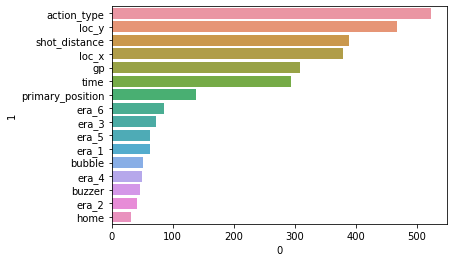

In [9]:
imp = pd.DataFrame(zip(pipe.steps[1][1].feature_importances_,X_train.columns))

sns.barplot(x=0, y=1, data=imp.sort_values(by=0, ascending=False))

Calibration of different models

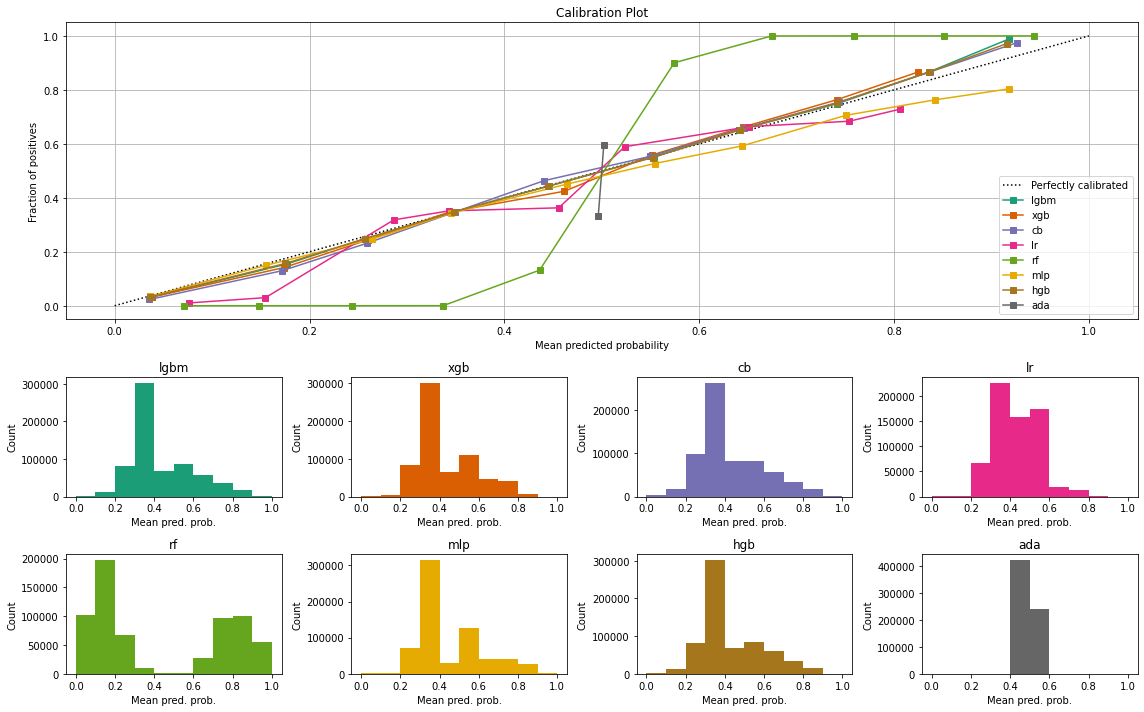

In [18]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

clfs = [
        (LGBMClassifier(),'lgbm'),
        (XGBClassifier(),'xgb'),
        (CatBoostClassifier(verbose=False),'cb'),
        (LogisticRegression(max_iter=1000),'lr'),
        (RandomForestClassifier(),'rf'),
        (MLPClassifier(),'mlp'),
        (HistGradientBoostingClassifier(),'hgb'),
        (AdaBoostClassifier(),'ada'),
        ]

models = pd.DataFrame()

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :4])
calibration_displays = {}

for i, (clf, name) in enumerate(clfs):
    pipe = make_pipeline(ce.OrdinalEncoder(), clf)
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
        pipe,
        X_train,
        y_train,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

    preds = pipe.predict_proba(X_train)

    acc = accuracy_score(y_train,np.round(preds[:,1]))
    ll = log_loss(y_train,preds[:,1])
    p = precision_score(y_train,np.round(preds[:,1]))
    r = recall_score(y_train,np.round(preds[:,1]))
    f1 = f1_score(y_train,np.round(preds[:,1]))
    ra = roc_auc_score(y_train,np.round(preds[:,1]))
    t = round(end-start,2)

    model = pd.DataFrame(
        {
          'accuracy':[acc],
          'logloss':[ll],
          'precision':[p],
          'recall':[r],
          'f1':[f1],
          'roc_auc':[ra],
          'time':[t]
        }
        ,index=[name])

    models = models.append(model)

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot")

grid_positions = [
                  (2, 0), (2, 1), (2, 2), (2, 3),
                  (3, 0), (3, 1), (3, 2), (3, 3)
                  ]

for i, (_, name) in enumerate(clfs):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean pred. prob.", ylabel="Count")

plt.tight_layout()

In [19]:
models

,accuracy,logloss,precision,recall,f1,roc_auc,time
lgbm,0.656878,0.626466,0.644334,0.442628,0.524766,0.629907,8.67
xgb,0.654061,0.631847,0.632433,0.457781,0.531117,0.629353,46.77
cb,0.662788,0.616284,0.654048,0.450284,0.533367,0.636037,254.43
lr,0.635544,0.658963,0.601753,0.438972,0.507632,0.610799,11.04
rf,0.999688,0.181549,0.999590,0.999682,0.999636,0.999687,168.32
mlp,0.643387,0.639753,0.598688,0.505881,0.548386,0.626077,1911.12
hgb,0.656521,0.626629,0.643473,0.442819,0.524614,0.629619,21.46
ada,0.642311,0.690884,0.597190,0.504668,0.547045,0.624984,32.83


RF extremely ovefits

In [22]:
train = df.loc[df.year < 2021]
test = df.loc[df.year == 2021]

X_train = train[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = train['shot_made_flag']

X_test = test[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_test = test['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), RandomForestClassifier())

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_test)

print(accuracy_score(y_test,np.round(preds[:,1])))
print(log_loss(y_test,preds[:,1]))

0.6084738665346987
0.6723057573278111


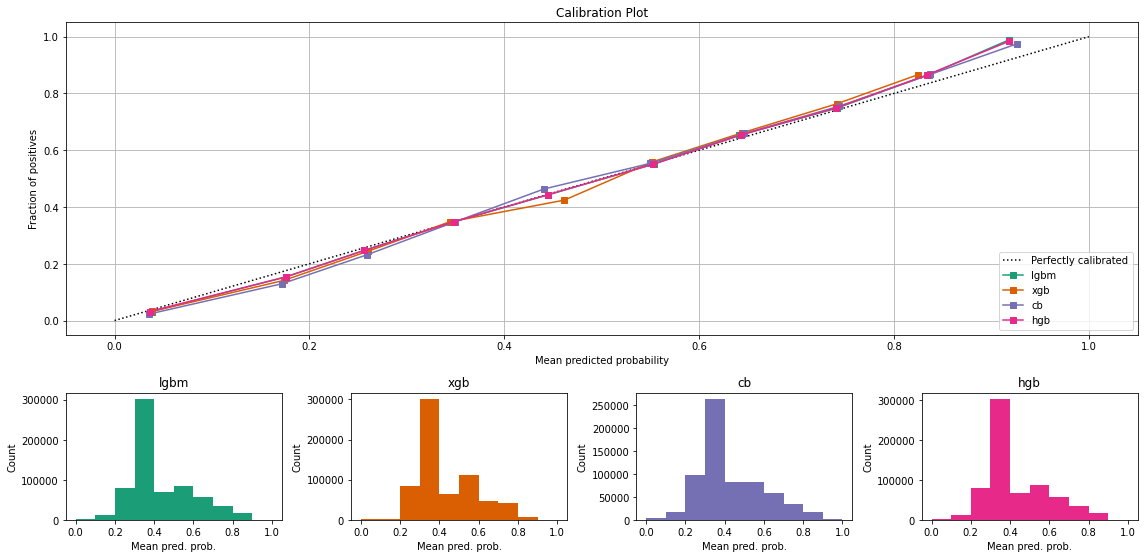

In [16]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

clfs = [
        (LGBMClassifier(),'lgbm'),
        (XGBClassifier(),'xgb'),
        (CatBoostClassifier(verbose=False),'cb'),
        (HistGradientBoostingClassifier(),'hgb'),
        ]

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :4])
calibration_displays = {}

models = pd.DataFrame()

for i, (clf, name) in enumerate(clfs):
    pipe = make_pipeline(ce.OrdinalEncoder(), clf)
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
        pipe,
        X_train,
        y_train,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

    preds = pipe.predict_proba(X_train)

    acc = accuracy_score(y_train,np.round(preds[:,1]))
    ll = log_loss(y_train,preds[:,1])
    p = precision_score(y_train,np.round(preds[:,1]))
    r = recall_score(y_train,np.round(preds[:,1]))
    f1 = f1_score(y_train,np.round(preds[:,1]))
    ra = roc_auc_score(y_train,np.round(preds[:,1]))
    cal = np.absolute((display.prob_pred - display.prob_true).mean())
    t = round(end-start,2)

    model = pd.DataFrame(
        {
          'accuracy':[acc],
          'logloss':[ll],
          'precision':[p],
          'recall':[r],
          'f1':[f1],
          'roc_auc':[ra],
          'cal':[cal],
          'time':[t]
        }
        ,index=[name])

    models = models.append(model)

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot")

grid_positions = [
                  (2, 0), (2, 1), (2, 2), (2, 3),
                  (3, 0), (3, 1), (3, 2), (3, 3)
                  ]

for i, (_, name) in enumerate(clfs):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean pred. prob.", ylabel="Count")

plt.tight_layout()

In [17]:
models

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
lgbm,0.656878,0.626466,0.644334,0.442628,0.524766,0.629907,0.007794,11.76
xgb,0.654061,0.631847,0.632433,0.457781,0.531117,0.629353,0.000072,40.40
cb,0.662788,0.616284,0.654048,0.450284,0.533367,0.636037,0.004447,247.44
hgb,0.656795,0.626517,0.643456,0.444294,0.525642,0.630044,0.007548,21.33


Tuning LGBM

In [36]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())

params = {
    "lgbmclassifier__objective" : ['binary'],
    "lgbmclassifier__max_depth" : [1,3,6,9,12,15],
    "lgbmclassifier__learning_rate" : [0.01, 0.05, 0.1, 0.2, 0.3,0.4],
    "lgbmclassifier__num_leaves" : [100,300,500,700,1000],
    "lgbmclassifier__n_estimators":[100,300,500,700,1000],
    "lgbmclassifier__boosting":['gbdt']
}

search=RandomizedSearchCV(pipe,
                   params,
                   n_iter=10,
                   scoring='neg_log_loss',
                   n_jobs=-1,
                   cv=5,
                   random_state=42, verbose=2
                   )

In [37]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('lgbmclassifier',
                                              LGBMClassifier())]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__boosting': ['gbdt'],
                                        'lgbmclassifier__learning_rate': [0.01,
                                                                          0.05,
                                                                          0.1,
                                                                          0.2,
                                                                          0.3,
                                                                          0.4],
                                        'lgbmclassifier__max_depth': [1, 3, 6,
                                                   

In [38]:
print(search.cv_results_['mean_test_score'].mean())
print(search.cv_results_['mean_test_score'].std())
print(search.cv_results_['mean_test_score'])

-0.6607374917113684
0.03324304372415434
[-0.63594135 -0.66431029 -0.64327237 -0.73751231 -0.63669343 -0.69455582
 -0.68681053 -0.63579005 -0.63594135 -0.63654741]


In [39]:
params_ = search.best_params_
params_

{'lgbmclassifier__boosting': 'gbdt',
 'lgbmclassifier__learning_rate': 0.01,
 'lgbmclassifier__max_depth': 12,
 'lgbmclassifier__n_estimators': 500,
 'lgbmclassifier__num_leaves': 100,
 'lgbmclassifier__objective': 'binary'}

LOSO

In [16]:
df_pred = pd.DataFrame()
df_actual = pd.DataFrame()

model = pd.DataFrame()

years = np.arange(df.year.min(),df.year.max()+1)

groups = df['year']

X = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y = df['shot_made_flag']

logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

logo.get_n_splits(groups=groups)

for year, (train_index, test_index) in zip(years, logo.split(X, y, groups)):
  print(f'Leaving out {year}...')
  
  X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
  y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
  
  pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())

  # pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier(
  #     boosting='gbdt',
  #     learning_rate=0.01,
  #     max_depth=12,
  #     n_estimators=500,
  #     num_leaves=100,
  #     objective='binary'
  #     )
  # )
  
  start = time.process_time()
  pipe.fit(X_train, y_train)
  end = time.process_time()

  display = CalibrationDisplay.from_estimator(
        pipe,
        X_test,
        y_test,
        n_bins=10,
    )
  plt.close()

  imps = list(dict(zip(pipe.steps[1][1].feature_importances_,X_test.columns)).items())

  X_test["make_pred"] = (pd.
                         DataFrame(pipe.predict_proba(X_test),index=X_test.index,columns=[0,"make_pred"])[["make_pred"]]
                         )

  ll = log_loss(y_test,X_test["make_pred"]) 
  acc = accuracy_score(y_test,np.round(X_test["make_pred"]))
  p = precision_score(y_test,np.round(X_test["make_pred"]))
  r = recall_score(y_test,np.round(X_test["make_pred"]))
  f1 = f1_score(y_test,np.round(X_test["make_pred"]))
  ra = roc_auc_score(y_test,np.round(X_test["make_pred"]))
  cal = np.absolute((display.prob_pred - display.prob_true).mean())
  t = round(end-start,2)

  group = pd.DataFrame(
    {
      'accuracy':[acc],
      'logloss':[ll],
      'precision':[p],
      'recall':[r],
      'f1':[f1],
      'roc_auc':[ra],
      'cal':[cal],
      'time':[t],
      'imps':[imps]
    }
    ,index=[year])

  model = model.append(group)

  df_pred = df_pred.append(X_test)
  df_actual = df_actual.append(y_test)

Leaving out 1997...
Leaving out 1998...
Leaving out 1999...
Leaving out 2000...
Leaving out 2001...
Leaving out 2002...
Leaving out 2003...
Leaving out 2004...
Leaving out 2005...
Leaving out 2006...
Leaving out 2007...
Leaving out 2008...
Leaving out 2009...
Leaving out 2010...
Leaving out 2011...
Leaving out 2012...
Leaving out 2013...
Leaving out 2014...
Leaving out 2015...
Leaving out 2016...
Leaving out 2017...
Leaving out 2018...
Leaving out 2019...
Leaving out 2020...
Leaving out 2021...


In [13]:
# action_type combining all dunks lgbm
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.638677,0.647523,0.611613,0.358617,0.452129,0.598287,0.017213,11.67,"[(376, shot_distance), (516, action_type), (37..."
1998,0.640333,0.645731,0.611637,0.411550,0.492030,0.609889,0.030431,11.68,"[(402, shot_distance), (491, action_type), (42..."
1999,0.644600,0.644136,0.620292,0.398270,0.485083,0.610744,0.000492,11.81,"[(421, shot_distance), (506, action_type), (38..."
2000,0.640906,0.645949,0.642999,0.379122,0.476999,0.609537,0.009167,11.63,"[(390, shot_distance), (511, action_type), (39..."
2001,0.659843,0.632692,0.641148,0.391877,0.486437,0.619386,0.021808,11.85,"[(405, shot_distance), (498, action_type), (38..."
2002,0.637796,0.646502,0.596604,0.427039,0.497778,0.608831,0.004852,11.64,"[(391, shot_distance), (499, action_type), (39..."
2003,0.646914,0.636549,0.606619,0.438585,0.509094,0.617391,0.021555,11.69,"[(416, shot_distance), (522, action_type), (36..."
2004,0.654980,0.629656,0.618308,0.467042,0.532134,0.629087,0.012530,11.52,"[(378, shot_distance), (527, action_type), (39..."
2005,0.656719,0.627471,0.628406,0.469337,0.537346,0.632207,0.003093,11.76,"[(401, shot_distance), (507, action_type), (37..."
2006,0.660446,0.623184,0.646458,0.443606,0.526157,0.632154,0.023259,11.44,"[(386, shot_distance), (503, action_type), (39..."


In [9]:
# shot_type_new lgbm
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.637430,0.649753,0.602488,0.375904,0.462959,0.599713,0.021636,11.84,"[(410, shot_distance), (264, shot_type_new), (..."
1998,0.638791,0.646619,0.606261,0.418184,0.494958,0.609436,0.000924,11.76,"[(452, shot_distance), (252, shot_type_new), (..."
1999,0.643899,0.645455,0.617355,0.401918,0.486869,0.610641,0.017109,12.01,"[(452, shot_distance), (248, shot_type_new), (..."
2000,0.641513,0.645859,0.639647,0.389413,0.484105,0.611304,0.013734,11.68,"[(429, shot_distance), (273, shot_type_new), (..."
2001,0.659509,0.633421,0.637774,0.397482,0.489741,0.619949,0.016360,11.72,"[(436, shot_distance), (265, shot_type_new), (..."
2002,0.637730,0.646648,0.595707,0.429899,0.499400,0.609166,0.046576,11.67,"[(442, shot_distance), (268, shot_type_new), (..."
2003,0.646598,0.637501,0.604284,0.444482,0.512208,0.617955,0.016826,11.70,"[(436, shot_distance), (240, shot_type_new), (..."
2004,0.654282,0.629637,0.616158,0.469627,0.533005,0.628841,0.017788,11.77,"[(415, shot_distance), (248, shot_type_new), (..."
2005,0.656289,0.628179,0.626836,0.471455,0.538154,0.632110,0.005296,11.66,"[(451, shot_distance), (241, shot_type_new), (..."
2006,0.660151,0.624601,0.646462,0.442065,0.525073,0.631697,0.013047,11.41,"[(430, shot_distance), (255, shot_type_new), (..."


In [12]:
# xgboost
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.639044,0.649616,0.608670,0.369025,0.459477,0.600102,0.016164,39.97,"[(0.35460597, shot_distance), (0.21415657, act..."
1998,0.634772,0.648516,0.597484,0.420135,0.493356,0.606211,0.008735,38.33,"[(0.08848818, shot_distance), (0.44708443, act..."
1999,0.642322,0.647149,0.615509,0.397123,0.482767,0.608621,0.006658,37.61,"[(0.0914798, shot_distance), (0.42256162, acti..."
2000,0.640772,0.648256,0.634752,0.396429,0.488051,0.611493,0.009963,37.73,"[(0.09229279, shot_distance), (0.44337937, act..."
2001,0.656971,0.633699,0.633727,0.392283,0.484596,0.617009,0.026435,37.18,"[(0.093346365, shot_distance), (0.41660392, ac..."
2002,0.636694,0.646942,0.593395,0.431011,0.499333,0.608427,0.000761,37.87,"[(0.08144786, shot_distance), (0.44625536, act..."
2003,0.644698,0.638776,0.599684,0.447767,0.512709,0.616790,0.011454,38.17,"[(0.0922931, shot_distance), (0.4262739, actio..."
2004,0.653584,0.631260,0.615040,0.468888,0.532111,0.628137,0.012773,38.24,"[(0.08646193, shot_distance), (0.43976277, act..."
2005,0.655702,0.630676,0.622455,0.481400,0.542915,0.632901,0.002601,37.44,"[(0.08848863, shot_distance), (0.45644906, act..."
2006,0.659824,0.627503,0.642464,0.449923,0.529225,0.632437,0.013141,36.91,"[(0.08995974, shot_distance), (0.44501674, act..."


In [10]:
# catboost
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.638310,0.650122,0.613141,0.352267,0.447457,0.597057,0.029425,236.94,"[(22.692173350390657, shot_distance), (28.4388..."
1998,0.640553,0.646007,0.612067,0.411681,0.492262,0.610098,0.009920,234.59,"[(16.05208733573355, shot_distance), (27.33554..."
1999,0.643812,0.645588,0.615786,0.405774,0.489193,0.611095,0.001222,236.54,"[(14.945722361784565, shot_distance), (27.9067..."
2000,0.639896,0.647326,0.638309,0.383722,0.479307,0.609199,0.025708,232.78,"[(15.107397895396842, shot_distance), (27.6987..."
2001,0.658875,0.633234,0.644463,0.379610,0.477787,0.616712,0.023372,239.11,"[(15.561847361178328, shot_distance), (26.8258..."
2002,0.638798,0.647223,0.599216,0.424815,0.497165,0.609389,0.010158,247.12,"[(14.75398764613639, shot_distance), (27.74068..."
2003,0.648004,0.636946,0.610419,0.433361,0.506873,0.617586,0.005281,245.81,"[(15.73561425931712, shot_distance), (26.95483..."
2004,0.653467,0.630341,0.616366,0.463811,0.529316,0.627338,0.019729,247.18,"[(14.226112259648277, shot_distance), (26.7752..."
2005,0.655390,0.628043,0.630626,0.455433,0.528899,0.629233,0.005636,246.76,"[(14.581181401750825, shot_distance), (27.4480..."
2006,0.661690,0.623743,0.655908,0.428968,0.518701,0.631326,0.019502,244.02,"[(15.281916947287968, shot_distance), (26.7324..."


In [94]:
# default lgbm
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.638604,0.647417,0.613755,0.352620,0.447905,0.597359,0.012540,10.05,"[(387, shot_distance), (528, action_type), (40..."
1998,0.639727,0.645782,0.609411,0.414412,0.493342,0.609745,0.021870,8.73,"[(404, shot_distance), (468, action_type), (41..."
1999,0.643812,0.644291,0.620673,0.392433,0.480843,0.609262,0.001166,8.79,"[(413, shot_distance), (516, action_type), (38..."
2000,0.640368,0.645784,0.642167,0.378031,0.475905,0.608932,0.006567,8.66,"[(427, shot_distance), (510, action_type), (38..."
2001,0.659743,0.632735,0.641231,0.391145,0.485897,0.619191,0.013000,8.70,"[(391, shot_distance), (509, action_type), (40..."
2002,0.637830,0.646407,0.596627,0.427198,0.497894,0.608882,0.003791,9.26,"[(393, shot_distance), (482, action_type), (39..."
2003,0.646703,0.637045,0.605312,0.441618,0.510667,0.617639,0.010667,8.75,"[(393, shot_distance), (515, action_type), (37..."
2004,0.654398,0.629631,0.617896,0.464734,0.530481,0.628267,0.015116,8.69,"[(375, shot_distance), (484, loc_y), (415, loc..."
2005,0.656524,0.627574,0.627798,0.469982,0.537546,0.632122,0.002526,8.73,"[(387, shot_distance), (498, action_type), (37..."
2006,0.660413,0.623052,0.646946,0.442296,0.525396,0.631955,0.024314,8.87,"[(394, shot_distance), (499, action_type), (36..."


In [42]:
# tuned lgbm
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.640070,0.648872,0.616396,0.355442,0.450884,0.599021,0.000669,53.73,"[(398, shot_distance), (501, action_type), (39..."
1998,0.640553,0.647183,0.617569,0.395942,0.482524,0.608003,0.007902,55.49,"[(398, shot_distance), (501, action_type), (39..."
1999,0.644688,0.645353,0.623543,0.390348,0.480128,0.609731,0.042972,53.14,"[(398, shot_distance), (501, action_type), (39..."
2000,0.641041,0.646949,0.643415,0.378966,0.476990,0.609637,0.022422,53.63,"[(398, shot_distance), (501, action_type), (39..."
2001,0.661179,0.631959,0.644885,0.391227,0.487006,0.620422,0.012211,53.93,"[(398, shot_distance), (501, action_type), (39..."
2002,0.638631,0.645039,0.598659,0.425610,0.497516,0.609355,0.001314,53.41,"[(398, shot_distance), (501, action_type), (39..."
2003,0.647231,0.637254,0.608444,0.434625,0.507052,0.617101,0.004420,53.91,"[(398, shot_distance), (501, action_type), (39..."
2004,0.654708,0.630833,0.619799,0.460672,0.528518,0.627975,0.012531,54.17,"[(398, shot_distance), (501, action_type), (39..."
2005,0.656954,0.626896,0.629994,0.466114,0.535803,0.631990,0.003352,53.38,"[(398, shot_distance), (501, action_type), (39..."
2006,0.661297,0.622802,0.649393,0.441217,0.525437,0.632583,0.016598,52.95,"[(398, shot_distance), (501, action_type), (39..."


Looks like the default LGBM is the most fast, accurate, and calibrated model. Sometimes you gotta keep things simple!

### Multiple different era models

In [125]:
one = df.loc[(df.year.between(1997,2000))].copy()
two = df.loc[(df.year.between(2001,2004))].copy()
three = df.loc[(df.year.between(2005,2008))].copy()
four = df.loc[(df.year.between(2009,2012))].copy()
five = df.loc[(df.year.between(2013,2016))].copy()
six = df.loc[(df.year>=2017)].copy()

models = [one,two,three,four,five,six]


df_pred = pd.DataFrame()
df_actual = pd.DataFrame()
model = pd.DataFrame()

for m in models:
  years = np.arange(m.year.min(),m.year.max()+1)

  groups = m['year']

  X = m[['shot_distance','action_type','loc_x','loc_y','home','gp','time','buzzer','bubble','shot_zone_avg']]
  y = m['shot_made_flag']

  logo = LeaveOneGroupOut()
  logo.get_n_splits(X, y, groups)

  logo.get_n_splits(groups=groups)

  for year, (train_index, test_index) in zip(years, logo.split(X, y, groups)):
    print(f'Leaving out {year}...')
    
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
    pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())
    
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
          pipe,
          X_test,
          y_test,
          n_bins=10,
      )
    plt.close()

    imps = list(dict(zip(pipe.steps[1][1].feature_importances_,X_test.columns)).items())

    X_test["make_pred"] = (pd.
                          DataFrame(pipe.predict_proba(X_test),index=X_test.index,columns=[0,"make_pred"])[["make_pred"]]
                          )

    ll = log_loss(y_test,X_test["make_pred"]) 
    acc = accuracy_score(y_test,np.round(X_test["make_pred"]))
    p = precision_score(y_test,np.round(X_test["make_pred"]))
    r = recall_score(y_test,np.round(X_test["make_pred"]))
    f1 = f1_score(y_test,np.round(X_test["make_pred"]))
    ra = roc_auc_score(y_test,np.round(X_test["make_pred"]))
    cal = np.absolute((display.prob_pred - display.prob_true).mean())
    t = round(end-start,2)

    group = pd.DataFrame(
      {
        'accuracy':[acc],
        'logloss':[ll],
        'precision':[p],
        'recall':[r],
        'f1':[f1],
        'roc_auc':[ra],
        'cal':[cal],
        'time':[t],
        'imps':[imps]
      }
      ,index=[year])

    model = model.append(group)

    df_pred = df_pred.append(X_test)
    df_actual = df_actual.append(y_test)

Leaving out 1997...
Leaving out 1998...
Leaving out 1999...
Leaving out 2000...
Leaving out 2001...
Leaving out 2002...
Leaving out 2003...
Leaving out 2004...
Leaving out 2005...
Leaving out 2006...
Leaving out 2007...
Leaving out 2008...
Leaving out 2009...
Leaving out 2010...
Leaving out 2011...
Leaving out 2012...
Leaving out 2013...
Leaving out 2014...
Leaving out 2015...
Leaving out 2016...
Leaving out 2017...
Leaving out 2018...
Leaving out 2019...
Leaving out 2020...
Leaving out 2021...


In [126]:
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.626723,0.652083,0.576405,0.385253,0.461831,0.591899,0.009615,1.44,"[(243, shot_distance), (171, action_type), (49..."
1998,0.634772,0.648417,0.593772,0.434053,0.501503,0.608063,0.005766,1.26,"[(247, shot_distance), (136, action_type), (50..."
1999,0.639693,0.647044,0.607299,0.404107,0.485292,0.607314,0.006983,1.16,"[(252, shot_distance), (116, action_type), (45..."
2000,0.636697,0.651391,0.631382,0.381773,0.475830,0.606150,0.003519,1.04,"[(196, shot_distance), (119, action_type), (48..."
2001,0.659843,0.631775,0.636715,0.401787,0.492679,0.620882,0.013815,1.52,"[(260, shot_distance), (221, action_type), (41..."
2002,0.641202,0.645828,0.600348,0.437922,0.506430,0.613264,0.020726,1.57,"[(260, shot_distance), (212, action_type), (48..."
2003,0.644909,0.637003,0.604602,0.431676,0.503711,0.614691,0.003512,1.57,"[(263, shot_distance), (208, action_type), (46..."
2004,0.642685,0.639426,0.608731,0.418390,0.495924,0.611783,0.047578,1.61,"[(231, shot_distance), (182, action_type), (47..."
2005,0.651557,0.629200,0.643900,0.401934,0.494926,0.618903,0.005869,2.73,"[(244, shot_distance), (247, action_type), (49..."
2006,0.655011,0.623729,0.674475,0.363790,0.472649,0.617015,0.012340,1.82,"[(283, shot_distance), (277, action_type), (46..."


In [ ]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(round(p.pred_make), p["shot_made_flag"])

# fig, ax = plt.subplots(figsize=(10,8))

# sns.heatmap(cm, annot=True, fmt='g')

# plt.title('Confusion Matrix of Pass Completion Predictions')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')

Binning shot type

In [6]:
dunk = ['Reverse Dunk Shot','Reverse Dunk Shot','Driving Slam Dunk Shot','Cutting Dunk Shot','Running Dunk Shot','Slam Dunk Shot','Driving Dunk Shot','Dunk Shot','Putback Dunk Shot']

bankhook = ['Jump Bank Hook Shot','Running Bank Hook Shot','Driving Bank Hook Shot','Turnaround Bank Hook Shot','Hook Bank Shot']

fingerroll = ['Running Finger Roll Shot','Driving Finger Roll Shot','Finger Roll Shot','Cutting Finger Roll Layup Shot','Running Finger Roll Layup Shot','Finger Roll Layup Shot','Driving Finger Roll Layup Shot','Turnaround Finger Roll Shot']

speciallayup = ['Tip Layup Shot','Driving Reverse Layup Shot','Cutting Layup Shot','Running Layup Shot','Reverse Layup Shot','Putback Layup Shot',
                'Driving Layup Shot','Alley Oop Layup shot','Running Alley Oop Layup Shot','Running Reverse Layup Shot','Running Tip Shot','Tip Shot']

specialjump = ['Running Pull-Up Jump Shot','Driving Floating Bank Jump Shot','Driving Jump shot','Driving Floating Jump Shot','Floating Jump shot','Turnaround Fadeaway shot',
               'Step Back Jump shot','Fadeaway Jump Shot','Running Jump Shot','Turnaround Jump Shot','Pullup Jump shot','Turnaround Fadeaway Bank Jump Shot','Step Back Bank Jump Shot'
               ]

bank = ['Turnaround Bank shot','Running Bank shot','Jump Bank Shot','Driving Bank shot','Pullup Bank shot','Fadeaway Bank shot','']

hook = ['Driving Hook Shot','Turnaround Hook Shot','Hook Shot','Running Hook Shot','Jump Hook Shot']

In [7]:
df['shot_type_new'] = '0'
df.loc[df.action_type.isin(dunk), ['shot_type_new']] = 'dunk'
df.loc[df.action_type.isin(bankhook), ['shot_type_new']] = 'bank_hook'
df.loc[df.action_type.isin(fingerroll), ['shot_type_new']] = 'finger_roll'
df.loc[df.action_type.isin(speciallayup), ['shot_type_new']] = 'special_layup'
df.loc[df.action_type.isin(specialjump), ['shot_type_new']] = 'special_jump'
df.loc[df.action_type.isin(bank), ['shot_type_new']] = 'bank'
df.loc[df.action_type.isin(hook), ['shot_type_new']] = 'hook'
df.loc[df.action_type == 'Jump Shot', ['shot_type_new']] = 'jump_shot'
df.loc[df.action_type == 'Layup Shot', ['shot_type_new']] = 'layup_shot'

In [7]:
X_train = df[['shot_distance','shot_type_new','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']].copy()
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_train)

print(accuracy_score(y_train,np.round(preds[:,1])))
print(log_loss(y_train,preds[:,1]))

0.6552720954589208
0.628454654522286


Spontaneously trying optuna

In [5]:
!pip install optuna

     |████████████████████████████████| 308 kB 8.6 MB/s 
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 210 kB 54.3 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 146 kB 65.9 MB/s 
     |████████████████████████████████| 113 kB 51.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1fbd581144387290780c240216c93fed3d59f8d5694899036779baff3c12a7d9
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [12]:
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold

def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier(
            objective="binary",
            **param_grid)
            )
        pipe.fit(
            X_train,
            y_train,

        )
        preds = pipe.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
            # lgbmclassifier__eval_set=[(X_test, y_test)],
            # lgbmclassifier__eval_metric="binary_logloss",
            # lgbmclassifier__early_stopping_rounds=100,
            # lgbmclassifier__callbacks=[
            #     LightGBMPruningCallback(trial, "binary_logloss")
            # ]

In [13]:
X = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y = df['shot_made_flag']

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2022-04-24 17:36:30,413] A new study created in memory with name: LGBM Classifier
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
[I 2022-04-24 17:57:01,104] Trial 0 finished with value: 0.6332077414306755 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20194665525764732, 'num_leaves': 1920, 'max_depth': 9, 'min_data_in_leaf': 2800, 'lambda_l1': 85, 'lambda_l2': 25, 'min_gain_to_split': 1.4106790235696982, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6332077414306755.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=h

KeyboardInterrupt: ignored

Was taking way too long with no improvements over default params. 

In [14]:
print(f"\tBest value (log loss): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (log loss): 0.63321
	Best params:
		n_estimators: 10000
		learning_rate: 0.20194665525764732
		num_leaves: 1920
		max_depth: 9
		min_data_in_leaf: 2800
		lambda_l1: 85
		lambda_l2: 25
		min_gain_to_split: 1.4106790235696982
		bagging_fraction: 0.4
		bagging_freq: 1
		feature_fraction: 0.8


In [15]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier(
    n_estimators=10000,
		learning_rate=0.20194665525764732,
		num_leaves=1920,
		max_depth=9,
		min_data_in_leaf=2800,
		lambda_l1=85,
		lambda_l2=25,
		min_gain_to_split=1.4106790235696982,
		bagging_fraction=0.4,
		bagging_freq=1,
		feature_fraction=0.8
)
)

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_train)

print(accuracy_score(y_train,np.round(preds[:,1])))
print(log_loss(y_train,preds[:,1]))

0.6533181782408388
0.6319013752683377


Not even better than default params and takes way longer. Default LGBM will be the final model given its speed, performance, and calibration